In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
a = np.array([[0, 1],[2, 3]])

In [3]:
df = pd.DataFrame(a)

In [4]:
a

array([[0, 1],
       [2, 3]])

In [5]:
df

,0,1
0,0,1
1,2,3


In [6]:
df.iloc[[0,1]]

,0,1
0,0,1
1,2,3


In [7]:
df.iloc[[1,0]]

,0,1
1,2,3
0,0,1


In [8]:
df.loc[[1,0]]

,0,1
1,2,3
0,0,1


In [9]:
np.mod(-11.5, 7)

2.5

# Mechanics modeling

The goal of this challenge is to find ways to simulate the theoretical model finding process in physics or similar sciences. A good example is the paradigm shift between the Ptolemy and Copernical models of the universe.

In the challenge we start with the example above, and try to extend it to imaginary systems in which the motion of the objects in the sky could have completely different underlying mechanics that we don't know of.




The challenge consists of two parts: Classification and Regression. Both of these processes will also require Feature Extraction. The workflow can be briefly sketched as:




FLOW-CHART

In this tutorial, we will discuss the workflow elements in reverse order: Regression, FE_Reg, Classification, FE_clf, in order to understand the motivations better. We consider the regression to be the absolute problem, and every step added before is a tool that eases the task of its successor.





In the beginning, the task was simply to predict the future. Considering the early history of the birth of science, the capability of predicting the future was something that gave influential power to individuals; hence the investment of rulers to astrologers, and eventually to astronomers.

Scientific method was invented through this effort, marked by the Copernican revolution, which significantly boosted the predictive power of the models. While Ptolemy had a model that was able to (with sufficient amount of parameters) explain what has been observed, Copernican model was able to predict what came next.

In the terminology of ML, Ptolemy was able to achieve a good training score, but Copernicus was able to optimize training and test scores simultaneously. The observation of this led to the triumph of scientific method.

Getting inspired by this, we first focus on the regression problem, and then discuss how this leads to the formula classification to help solve it better.

## Regression problem and score

We will observe the angular position (phi) of the planet, and try to predict what this value will be in the future. The phi value takes values between [-pi,pi] and the values and the error is not supposed to scale with the value, therefore we have chosen RMS error as the score metric.

## Data format

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
data = pd.read_csv("data/data_ts_merged.csv")
data_x = pd.read_csv("data/data_x_merged.csv")
data_y = pd.read_csv("data/data_y_merged.csv")
ref_x = pd.read_csv("data/ref_x_merged.csv")
ref_y = pd.read_csv("data/ref_y_merged.csv")

print("shape : ", data.shape)
#data.iloc[:, [0, 1, 2, 3, 197, 198, 199, 200, 201]].head(10)



shape :  (200, 202)


The indices on the horizontal axis represent time steps with equal intervals, can be considered as the unit of time. The values of phi for these times are listed. Only these columns are available on the test sample, and the last two columns are the target columns.

The "future" column represents the value of phi at NNNN steps ahead. This is what we will try to predict in the regression problem.

The "system" column represents the mechanical system (set of formulas) that have been used to generate these values. It is also available in the training sample, and is helpful to separate the parts of the dataset from each other to fit a model to each system individually.




In [12]:
y_future = data['future'].values
y_system = data['system'].values
x_series = data.drop(['future', 'system'], axis=1).values

## Fitting a single time series

In [13]:
def plot_orbit(i_sample, t_min=0, t_max=-1):
    x = data_x.iloc[i_sample, range(t_max)].values[t_min:t_max]
    y = data_y.iloc[i_sample, range(t_max)].values[t_min:t_max]
    x0 = ref_x.iloc[i_sample, range(t_max)].values[t_min:t_max]
    y0 = ref_y.iloc[i_sample, range(t_max)].values[t_min:t_max]

    ax = plt.gca()
    ax.cla()
    ax.set_xlim([-120, 120])
    ax.set_ylim([-120, 120])
    plt.axes().set_aspect('equal')
    plt.scatter(x0, y0, color='r')
    plt.plot(x0, y0, color='r')
    plt.scatter(x, y)
    plt.plot(x, y)
    plt.show()

In [14]:
def plot_observation(i_sample, t_min=0, t_max=-1):
    phis = data.iloc[i_sample, range(t_max)].values[t_min:t_max]
    ax = plt.gca()
    ax.cla()
    ax.set_xlim([0, len(phis)])
    ax.set_ylim([-4.,4.])
    plt.xlabel('time')
    plt.ylabel('$\phi$')

    plt.scatter(range(len(phis)), phis)
    plt.plot(range(len(phis)), phis)
    plt.show()
    print("system is : ", y_system[i_sample])

In [15]:
def plot_data(i, t_min=0, t_max=-1):
    plot_orbit(i, t_min, t_max)
    plot_observation(i, t_min, t_max)

/anaconda/envs/python-flow/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


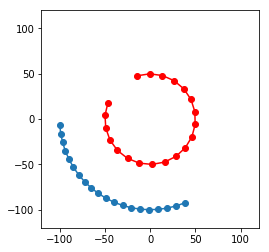

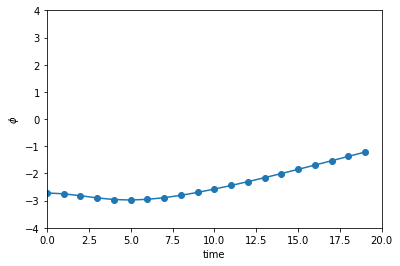

system is :  A


In [16]:
plot_data(31, 0, 20)

/anaconda/envs/python-flow/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


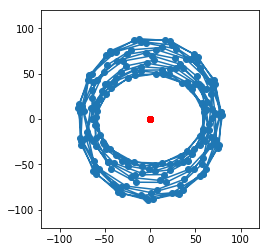

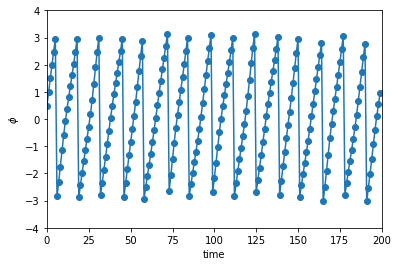

system is :  D


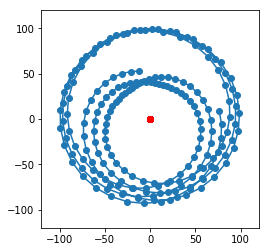

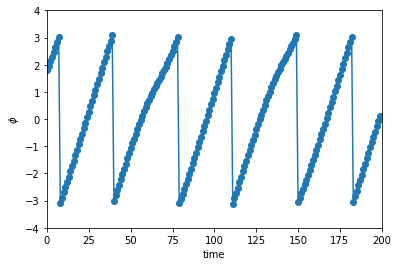

system is :  B


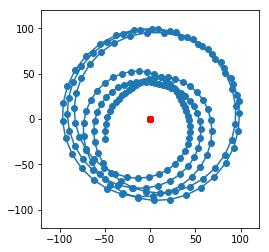

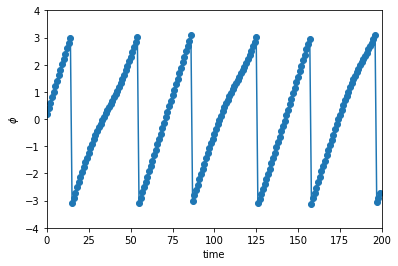

system is :  B


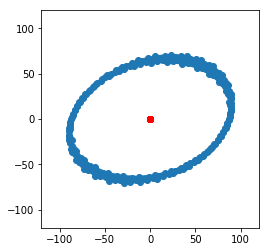

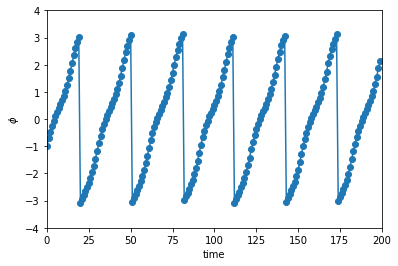

system is :  C


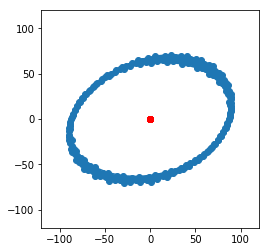

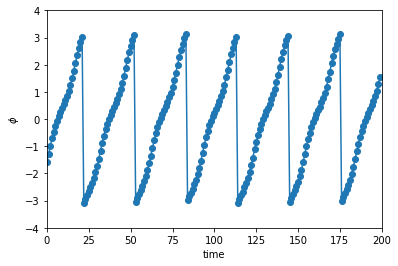

system is :  C


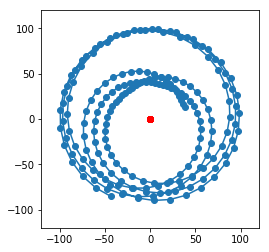

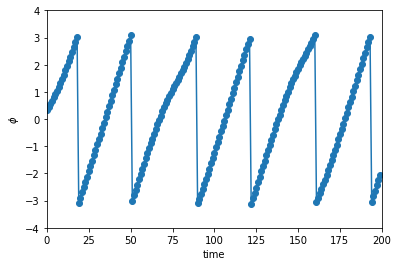

system is :  B


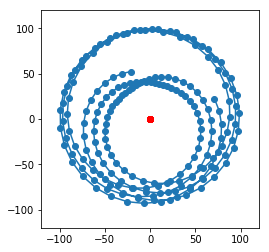

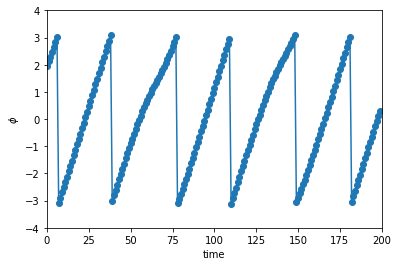

system is :  B


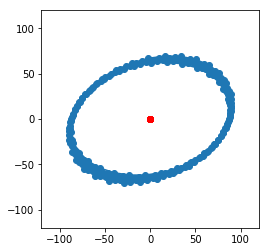

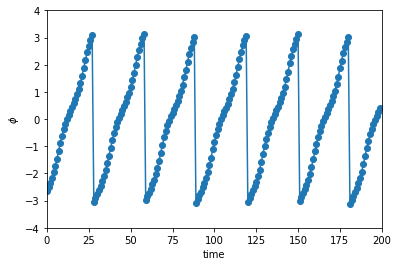

system is :  C


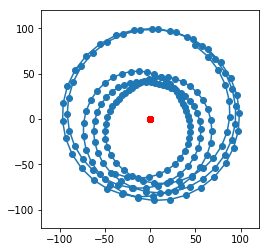

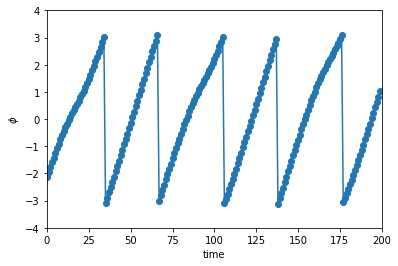

system is :  B


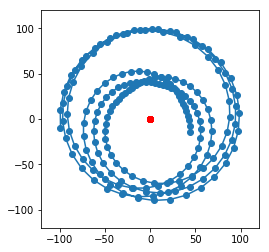

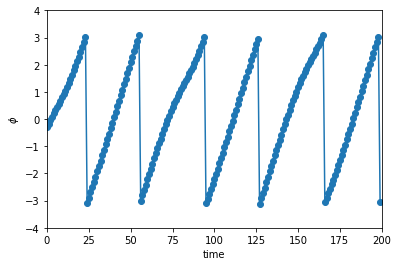

system is :  B


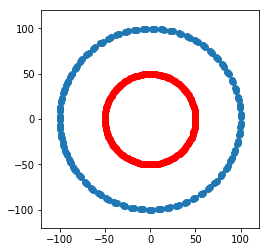

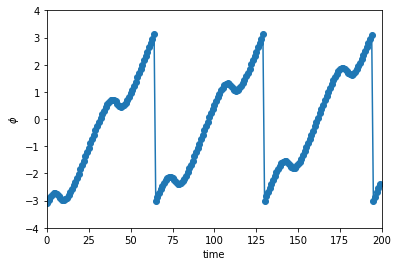

system is :  A


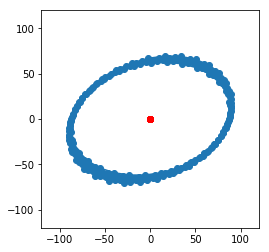

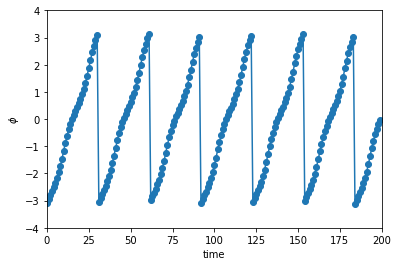

system is :  C


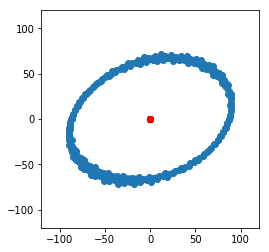

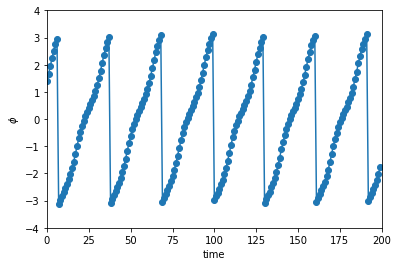

system is :  C


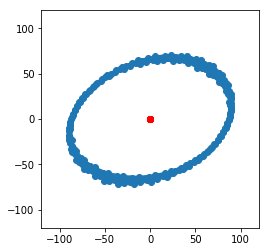

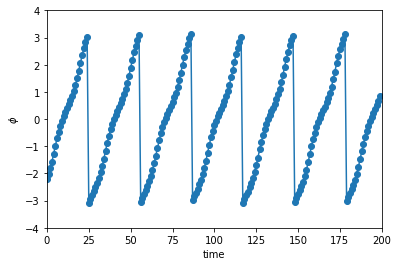

system is :  C


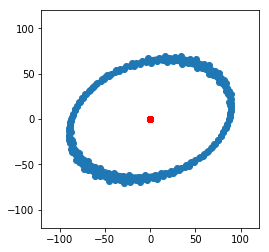

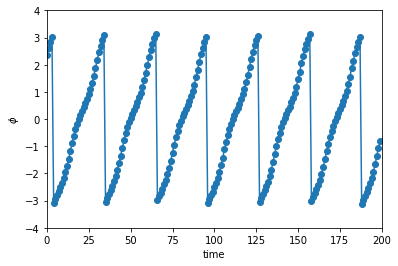

system is :  C


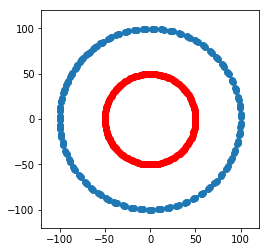

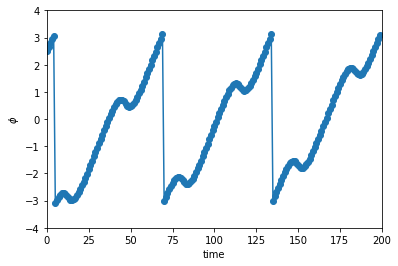

system is :  A


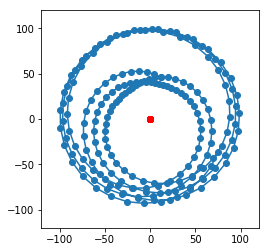

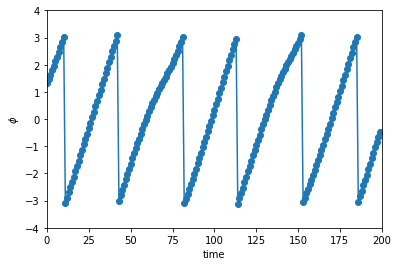

system is :  B


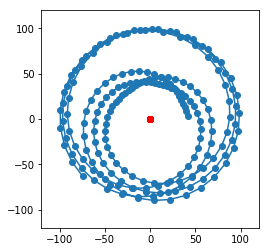

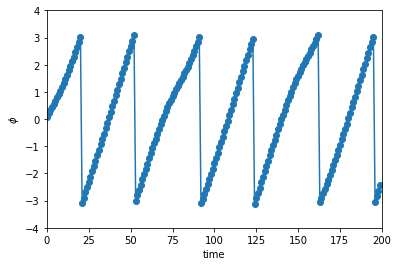

system is :  B


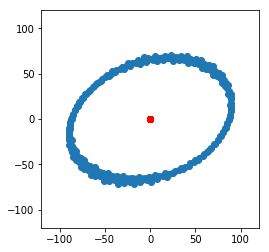

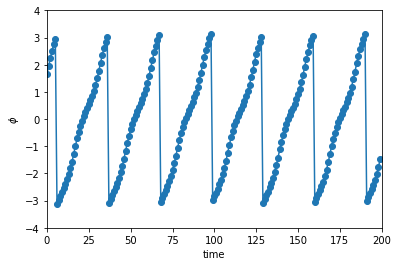

system is :  C


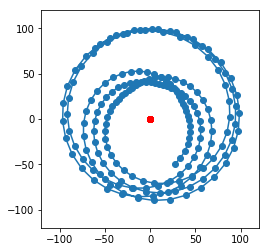

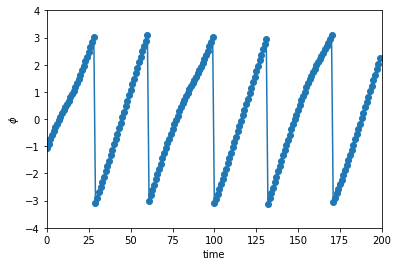

system is :  B


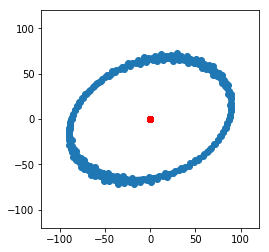

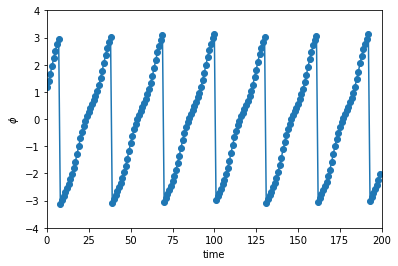

system is :  C


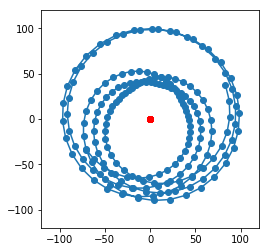

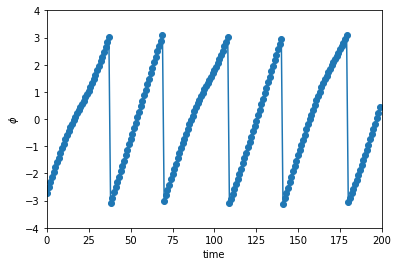

system is :  B


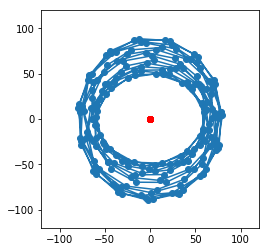

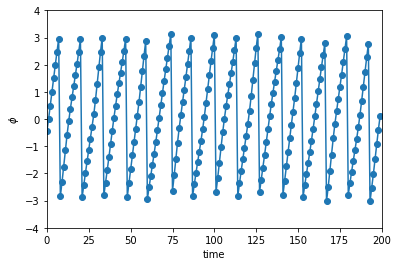

system is :  D


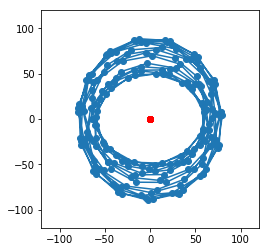

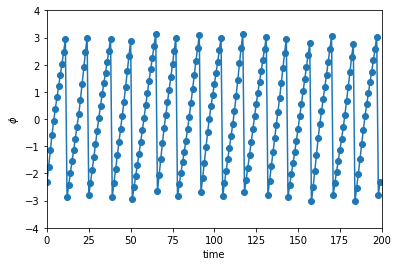

system is :  D


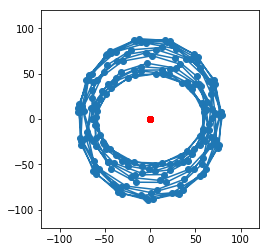

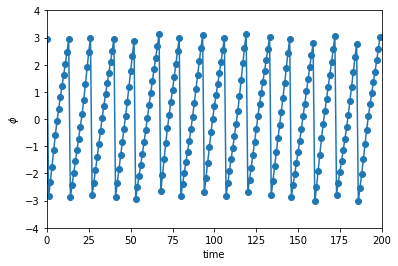

system is :  D


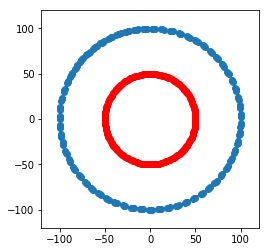

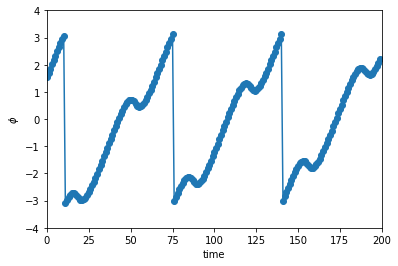

system is :  A


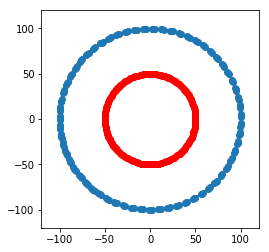

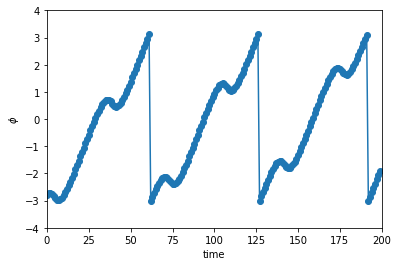

system is :  A


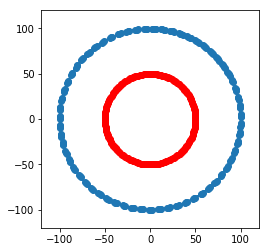

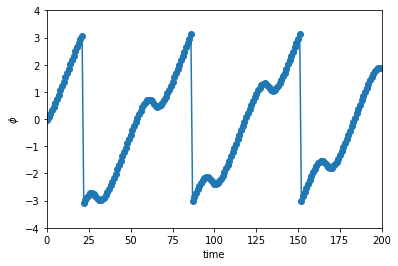

system is :  A


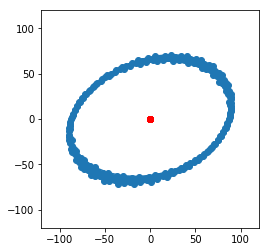

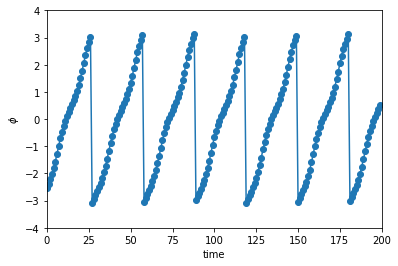

system is :  C


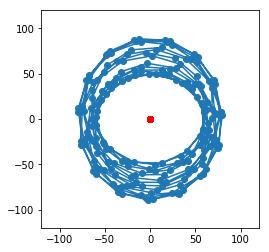

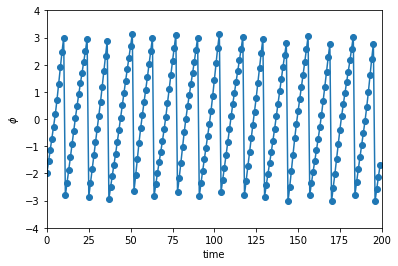

system is :  D


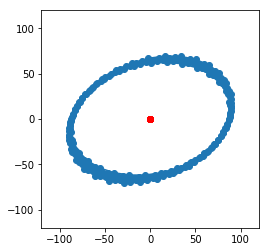

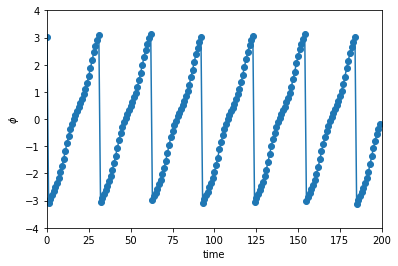

system is :  C


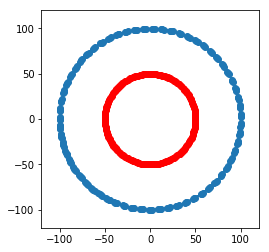

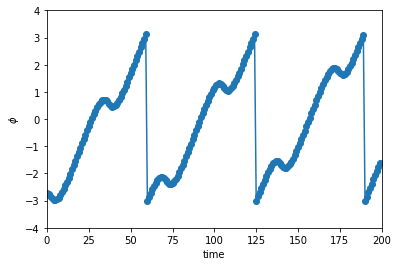

system is :  A


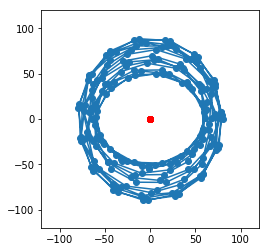

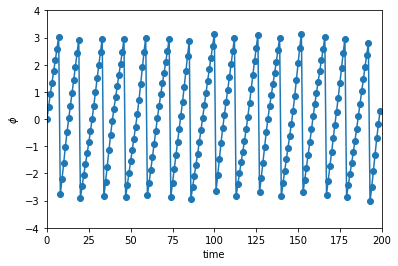

system is :  D


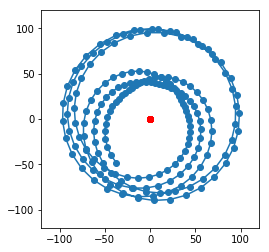

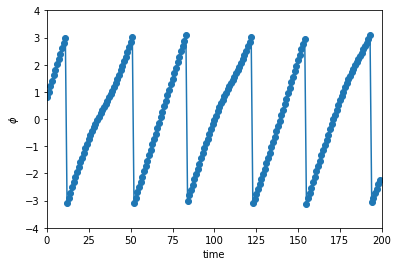

system is :  B


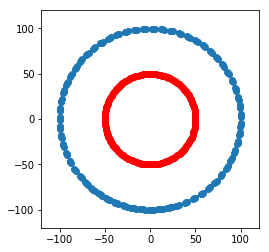

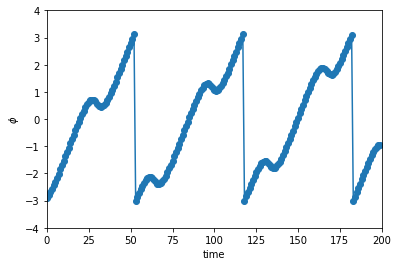

system is :  A


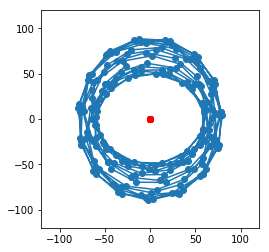

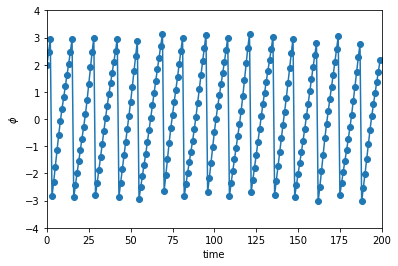

system is :  D


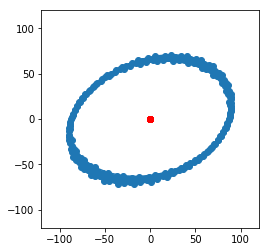

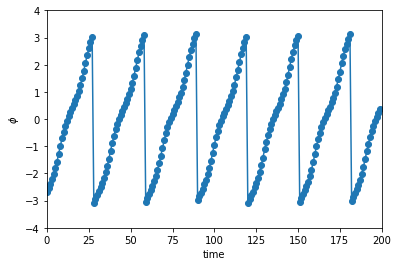

system is :  C


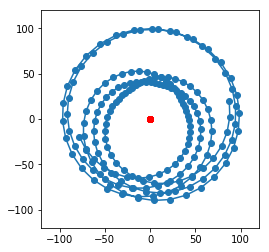

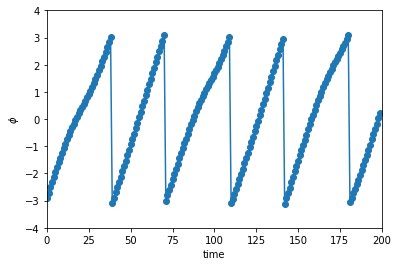

system is :  B


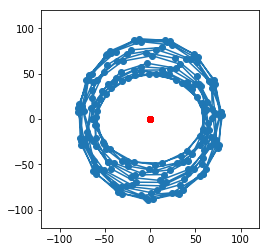

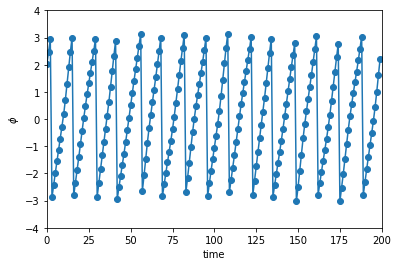

system is :  D


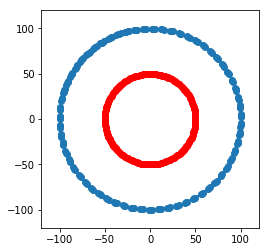

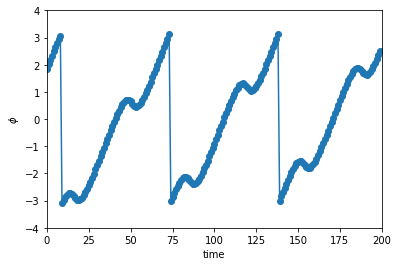

system is :  A


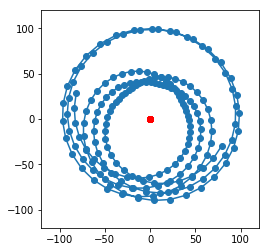

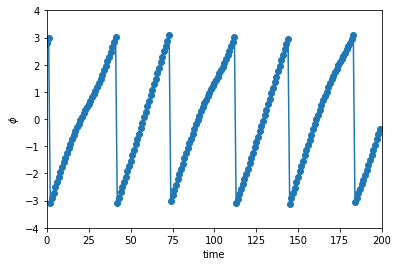

system is :  B


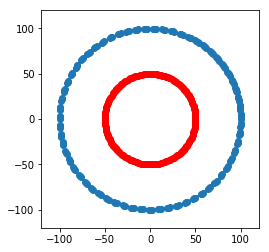

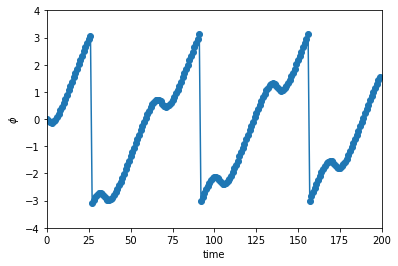

system is :  A


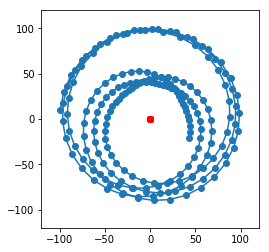

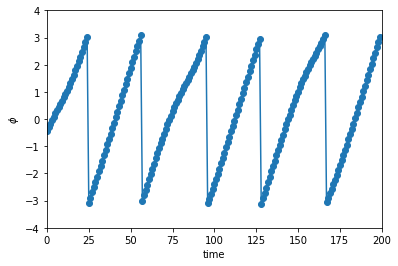

system is :  B


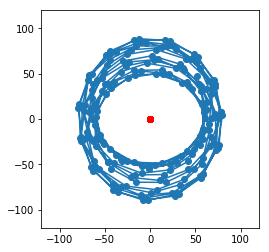

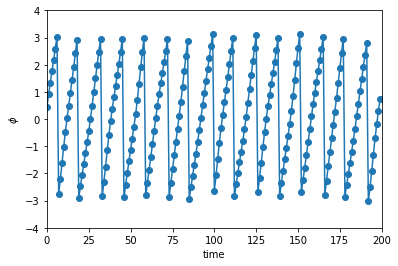

system is :  D


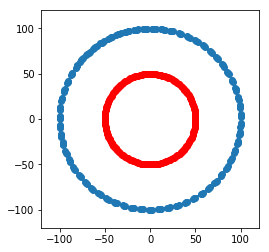

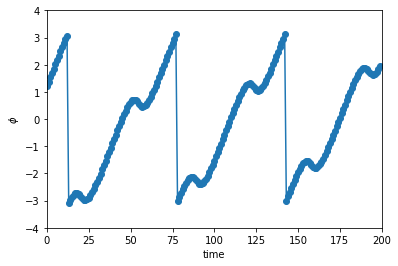

system is :  A


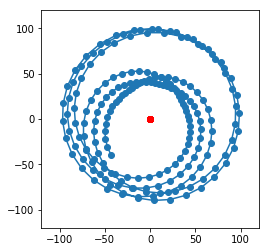

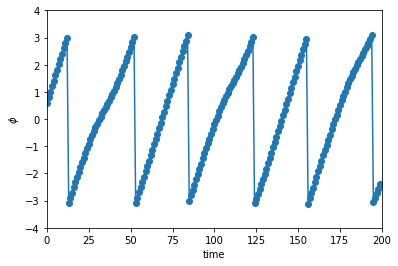

system is :  B


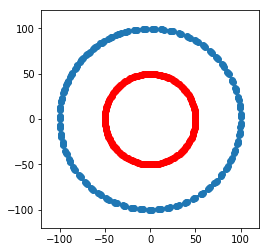

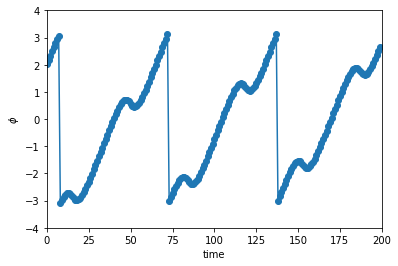

system is :  A


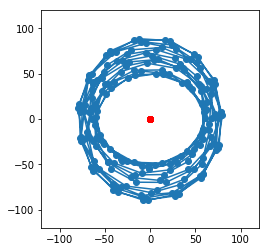

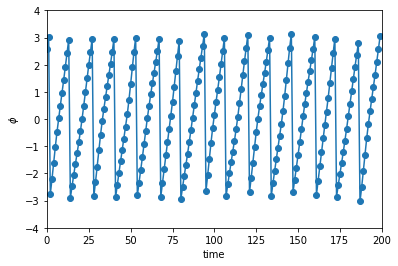

system is :  D


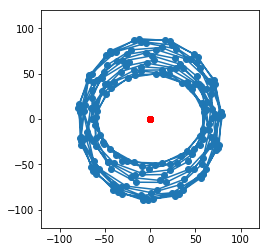

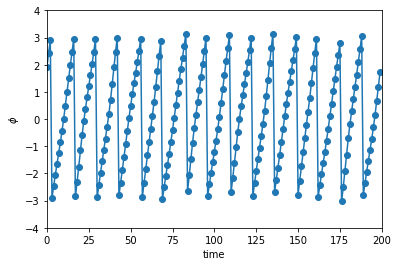

system is :  D


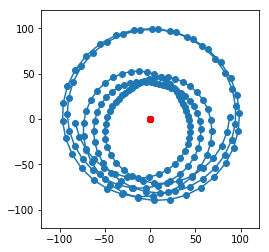

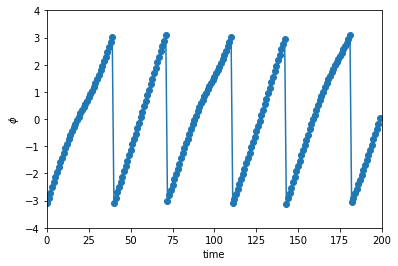

system is :  B


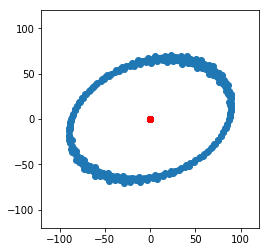

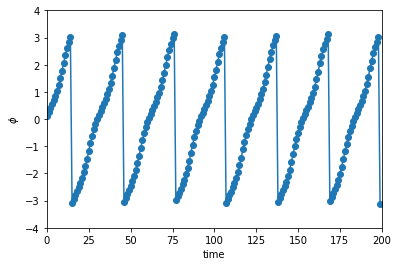

system is :  C


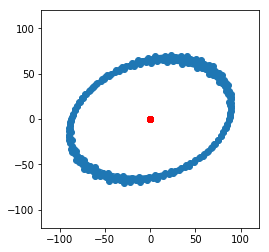

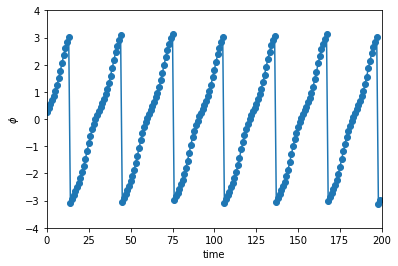

system is :  C


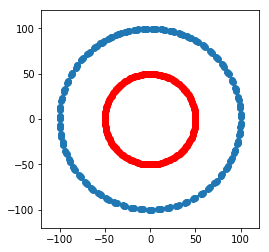

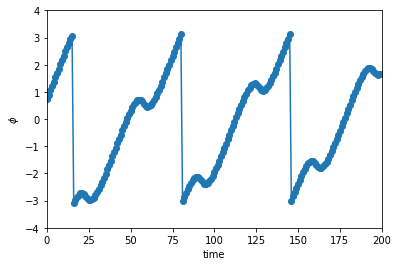

system is :  A


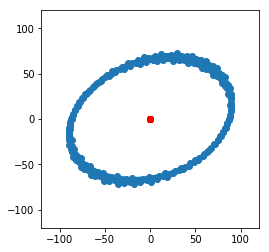

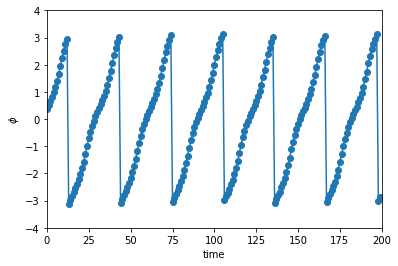

system is :  C


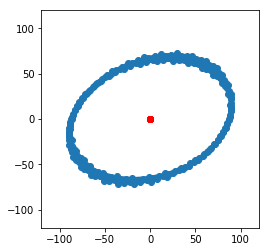

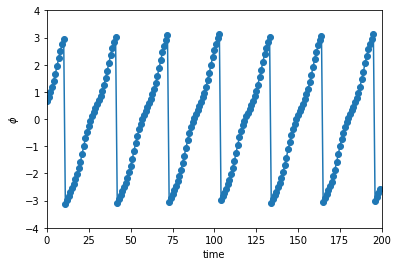

system is :  C


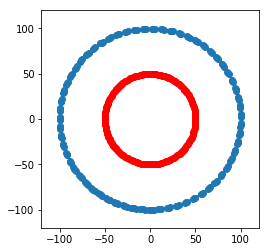

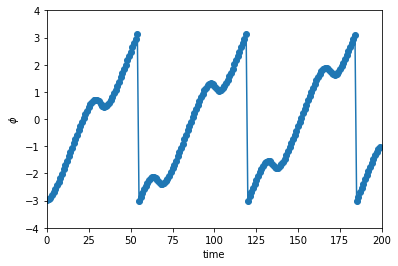

system is :  A


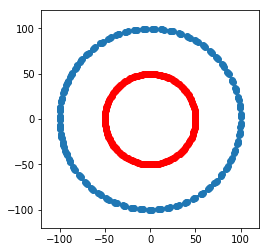

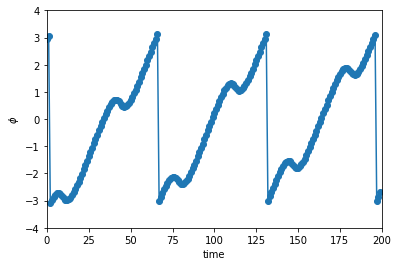

system is :  A


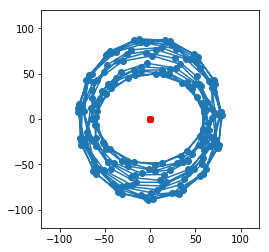

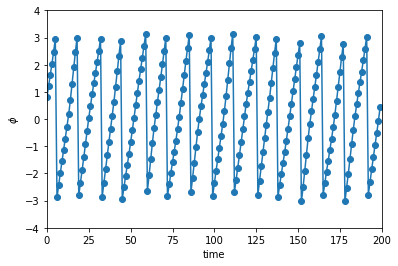

system is :  D


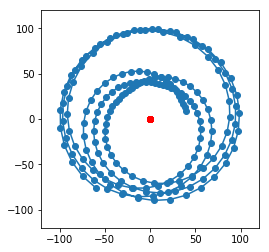

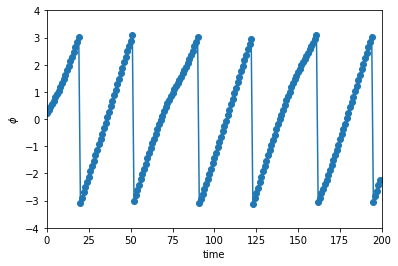

system is :  B


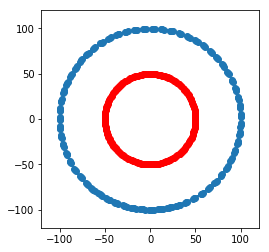

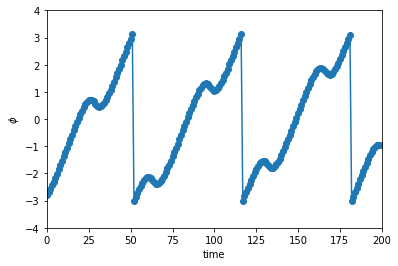

system is :  A


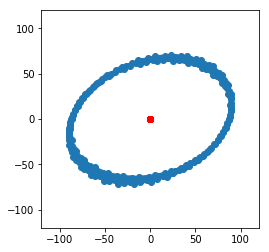

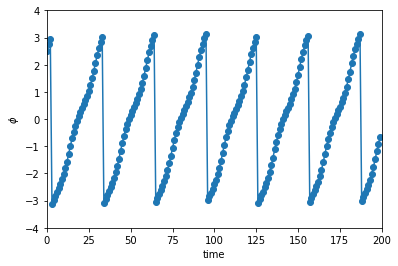

system is :  C


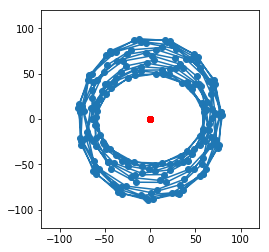

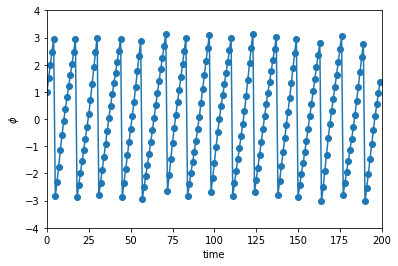

system is :  D


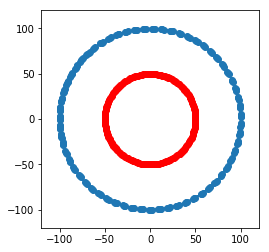

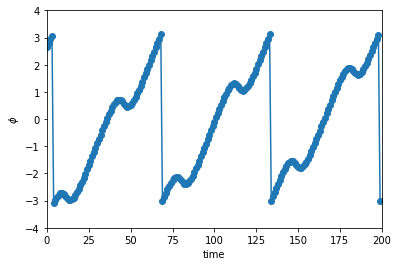

system is :  A


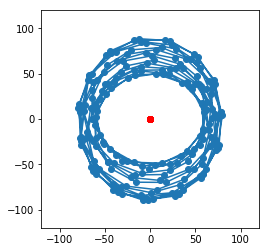

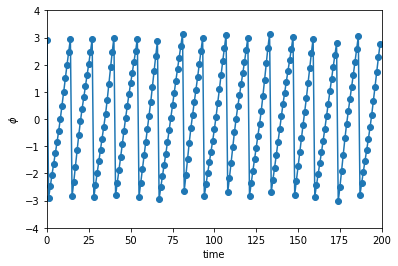

system is :  D


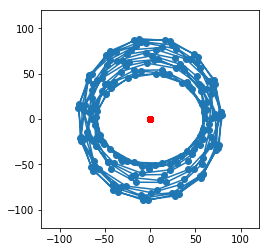

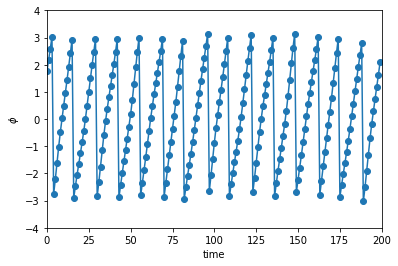

system is :  D


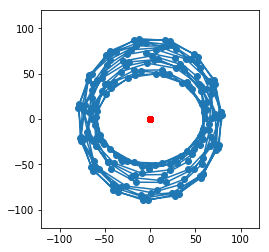

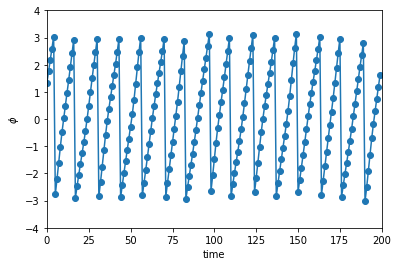

system is :  D


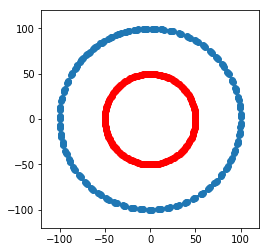

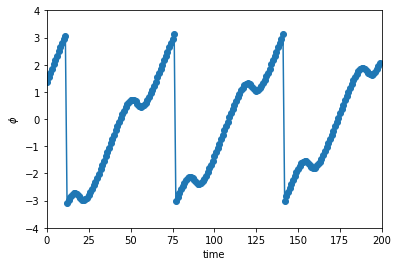

system is :  A


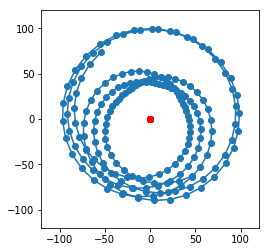

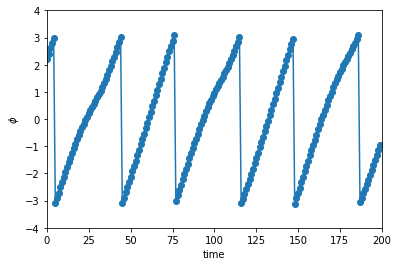

system is :  B


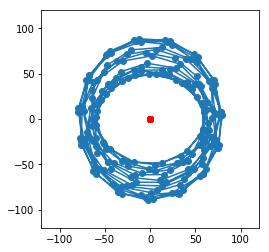

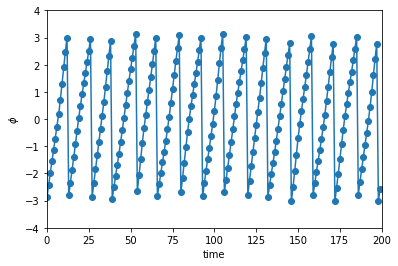

system is :  D


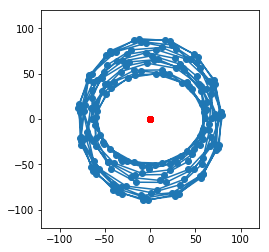

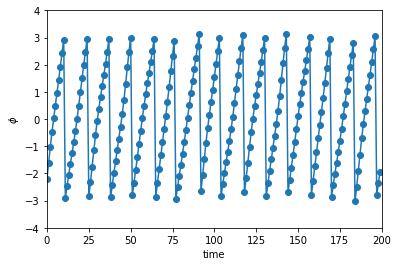

system is :  D


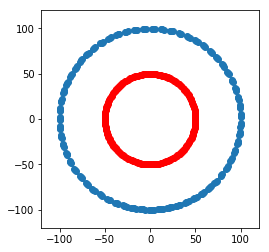

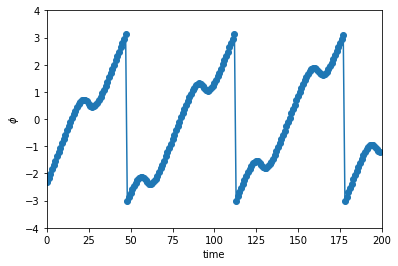

system is :  A


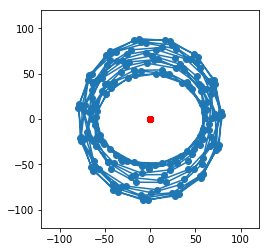

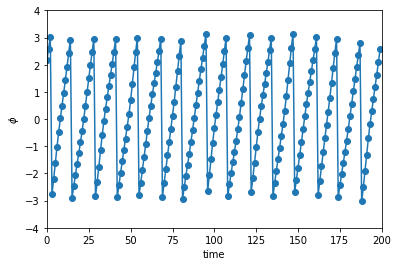

system is :  D


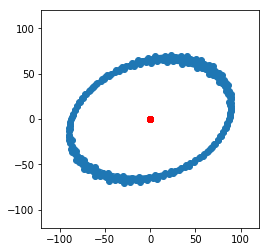

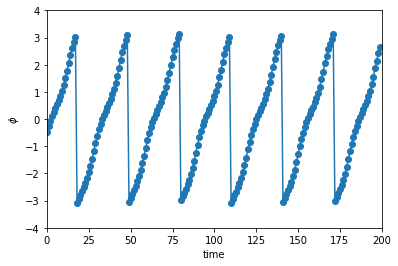

system is :  C


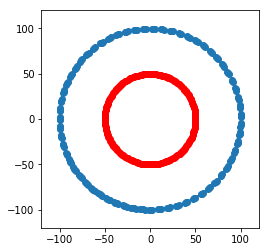

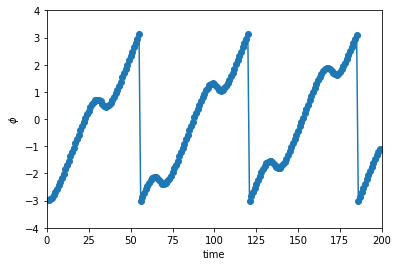

system is :  A


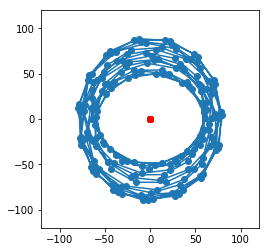

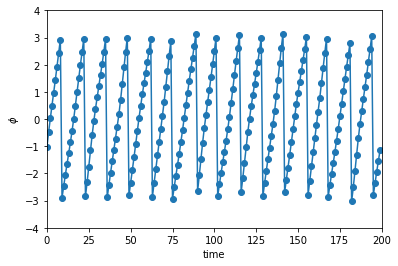

system is :  D


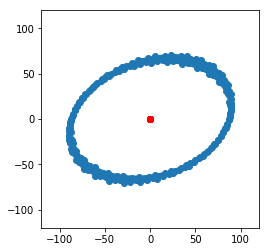

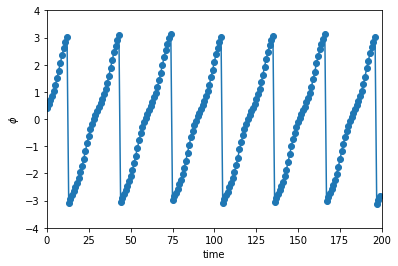

system is :  C


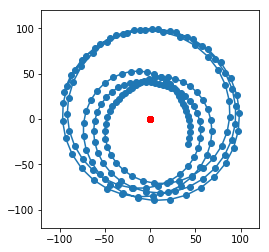

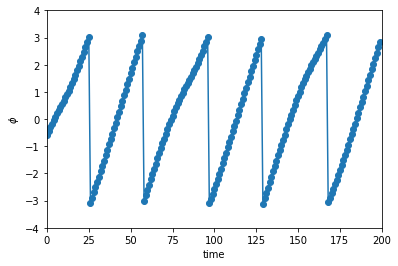

system is :  B


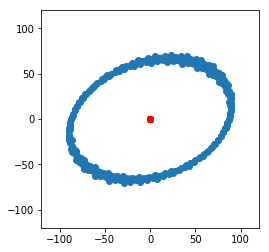

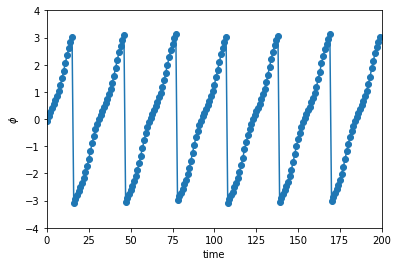

system is :  C


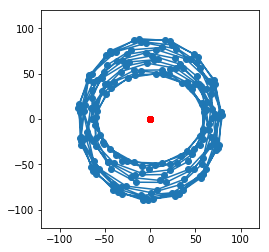

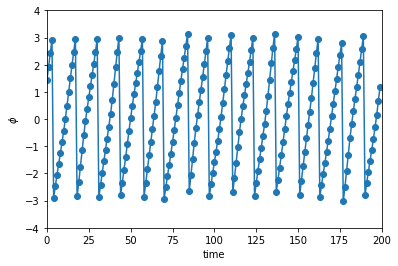

system is :  D


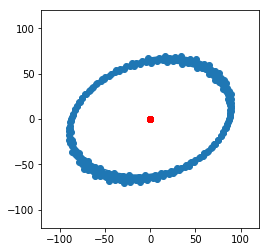

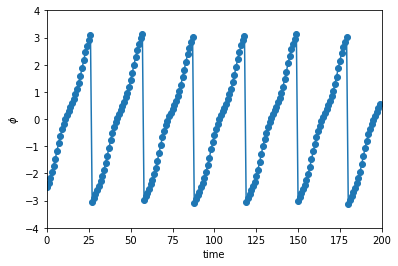

system is :  C


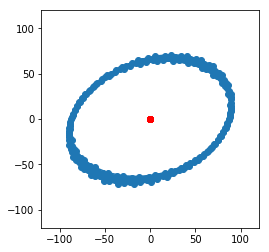

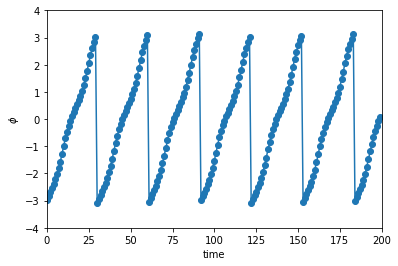

system is :  C


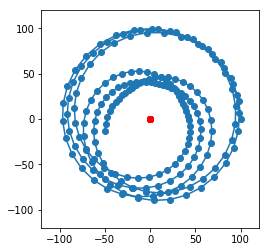

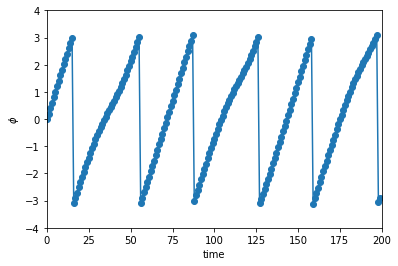

system is :  B


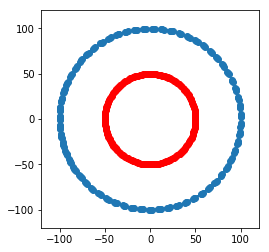

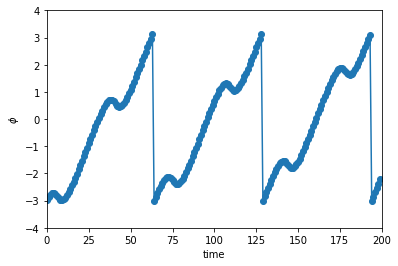

system is :  A


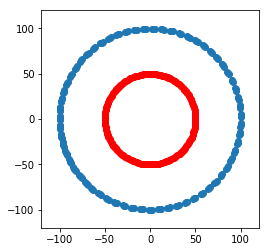

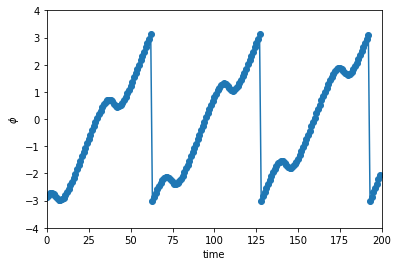

system is :  A


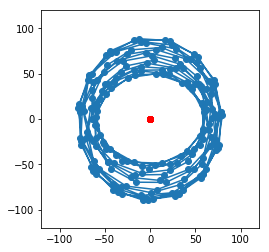

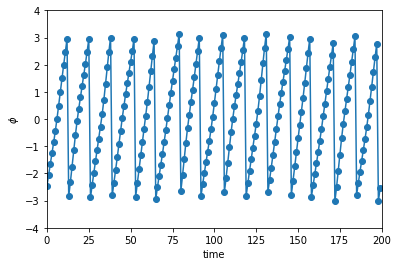

system is :  D


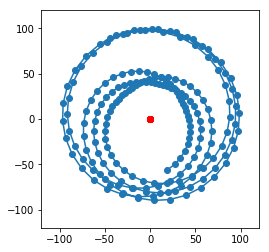

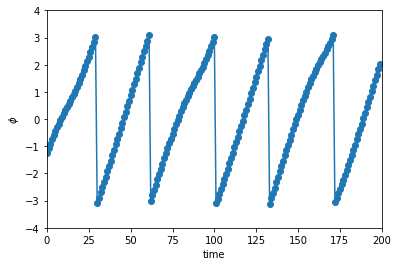

system is :  B


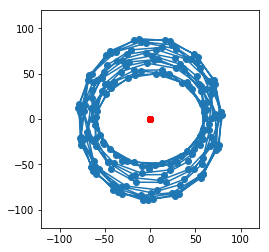

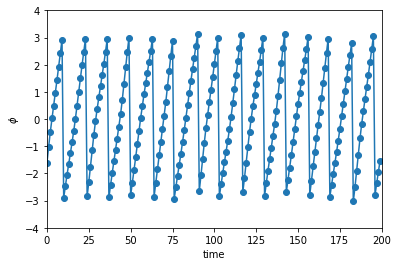

system is :  D


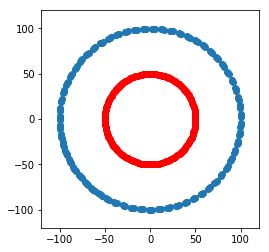

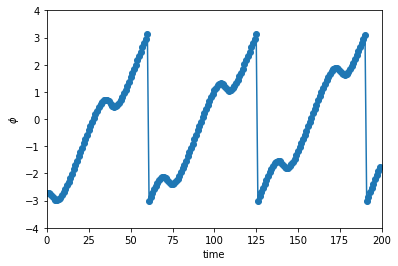

system is :  A


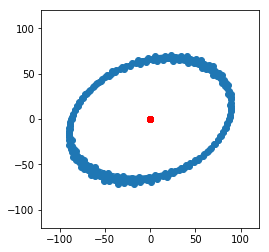

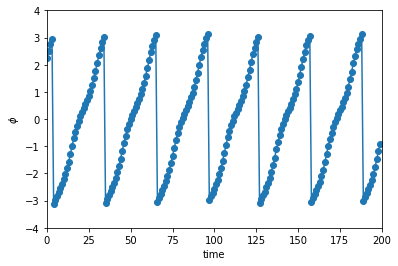

system is :  C


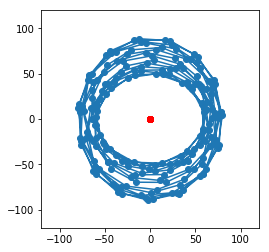

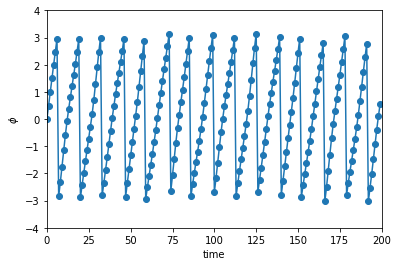

system is :  D


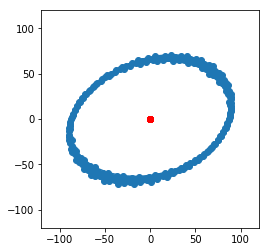

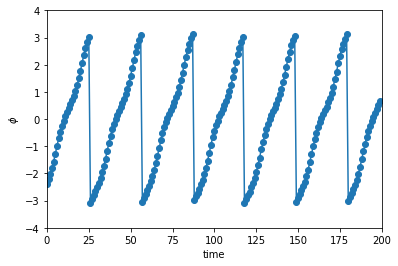

system is :  C


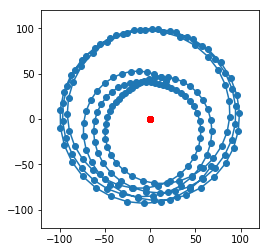

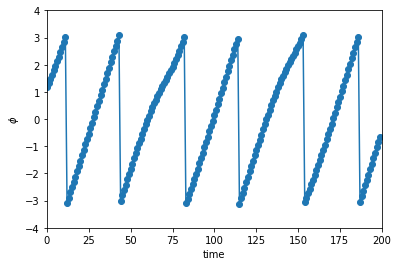

system is :  B


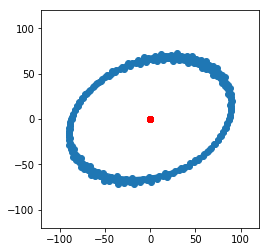

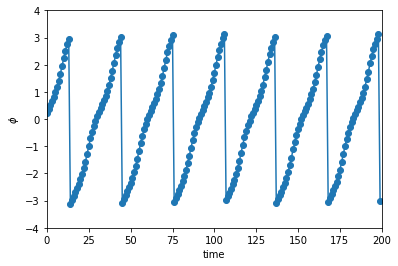

system is :  C


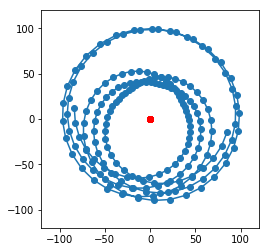

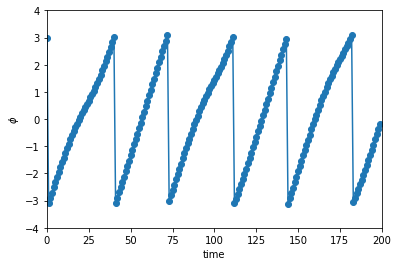

system is :  B


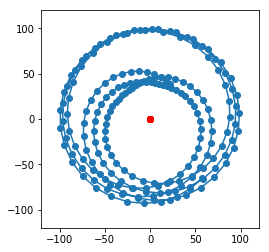

In [ ]:
for i in range(1000):
    plot_data(i, 0, 200)

Notice that this is a single row of the dataset. With only the information in a single row, we can already make a prediction of the future, if we make some assumptions. For example...

## starting_kit : Simple ML model

The starting kit is basically a template for all the functions to be implemented. It attempts to solve the classification and regression problems without any knowledge of the content and the discussion above. You can use this example to start implementing your own approach from complete scratch.

## Ptolemian model

### Tensorflow version for advanced optimization

## Copernican model

## Newtonian model

## LSTM model

## Using feature extractor to simplify data 

The above process could be performed either inside the predict() function, or, it can be performed in a transform() function in feature_extractor such that the data is now represented more efficiently and further regression methods can be applied to gain better accuracy.
In the available examples, most of the stuff happens in the feature_extractor_reg, and predict is only the identity function.

## Classification problem and score

Although so far  the classification part of the problem has been described as a helpful side task, it is essential to the main motivation of this challenge: Invent theoretical models in science.

Ideally, we would like to find the best functions that describe the data. In this challenge, we simplified this effort by assuming that the first step in generating the formula is to be able to classify a dataset into a set of given formulas. 

As the formula space is extended, the problem converges to theory generation.


## Scoring

Although there are two scores involved, we want to set the regression as the main score and treat the classification problem as a side product of the optimization for regression. We want, however, the participants to at least submit a non-trivial solution for classification therefore we assign a small but non-zero proportion for the combined score.

# TODO: Score rolls for 2pi

## Testing submission